In [1]:
%pwd

'/content'

In [8]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
def load_and_preprocess_data(base_dir, img_size=(299, 299)):
    images = [] # image data를 모으는 빈 리스트 생성
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']

    for category in categories:
        class_num = categories.index(category)
        base_path = os.path.join(base_dir, category)
        base_files = os.listdir(base_path)
        # print(base_files)
        np.random.shuffle(base_files)
        for idx in range(500):
          image_path = os.path.join(base_path, base_files[idx])
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, img_size)
          images.append(image)
          labels.append(class_num)

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    return images, np.array(labels)

def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42) # stratify: 클래스의 비율을 맞춰서 분할
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=val_size, stratify=y_val_test, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
base_dir = '/content/drive/MyDrive/ESG 2024/교안/실습/datasets/Pneumonia/train' # 드라이브의 개인 파일 경로 작성
X, y = load_and_preprocess_data(base_dir)

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (800, 299, 299, 1), 레이블 형태: (800,)
검증 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)
테스트 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)


In [5]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid') # Dense(2, activation='softmax'), model.compile(~~~, loss='sparse_crossentropy')
    ])
    return model

In [6]:
input_shape = (299, 299, 1) # 1: grayscale

model = create_simple_cnn(input_shape)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 322624)            0

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
model = tf.keras.models.load_model('best_model.h5') # 학습 후 가장 높은 성능을 나타낸 가중치를 불러오

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

4/4 [==============================] - 0s 20ms/step - loss: 0.3693 - accuracy: 0.8700
Test Accuracy: 0.8700


In [10]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred>0.5).astype(int).flatten()

4/4 [==============================] - 0s 21ms/step


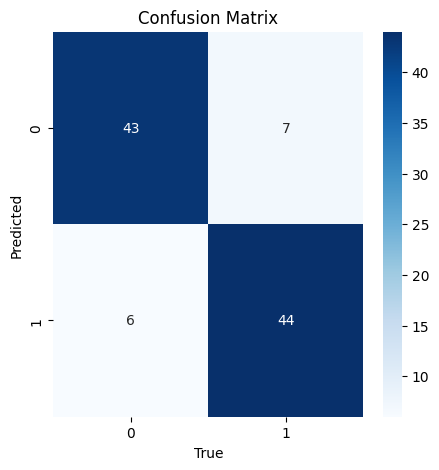

In [12]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

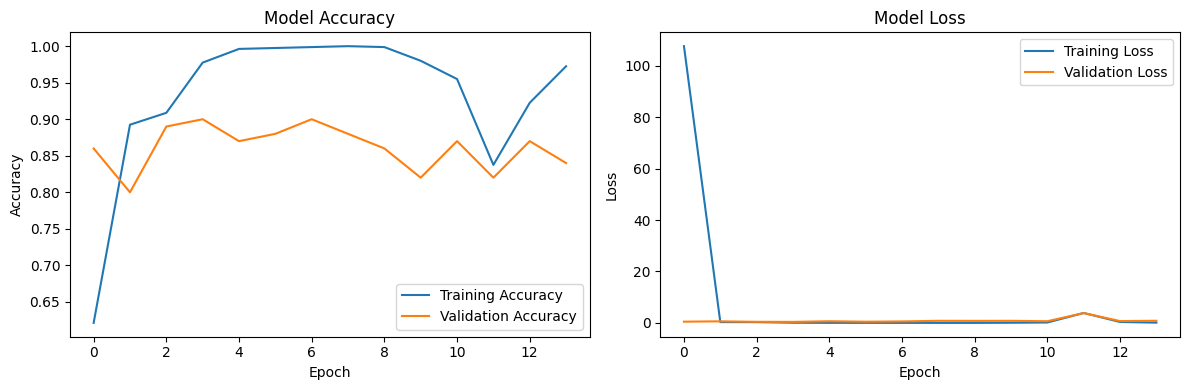

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## InceptionV3

In [15]:
from tensorflow.keras.applications import InceptionV3, noteResNet50V2, VGG16, Xception, EfficientNetB0, MobileNetV3Small,
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [20]:
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    # include_top: 전이 학습(transfer learning) True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    base_model.trainable = False

    # 완전 연결 계층(inference)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

### Inception용 data처리
- channel 1 -> 3

In [ ]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Inception용 전처리
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)

In [21]:
model = create_inceptionv3_model((299, 299, 3)) # 3: rgb
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)
]

87910968/87910968 [==============================] - 3s 0us/step


In [22]:
history = model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 22s 466ms/step - loss: 0.4557 - accuracy: 0.7725 - val_loss: 0.4169 - val_accuracy: 0.7900
Epoch 2/50
25/25 [==============================] - 5s 183ms/step - loss: 0.2581 - accuracy: 0.8975 - val_loss: 0.3312 - val_accuracy: 0.8300
Epoch 3/50
25/25 [==============================] - 5s 200ms/step - loss: 0.2072 - accuracy: 0.9125 - val_loss: 0.2654 - val_accuracy: 0.8800
Epoch 4/50
25/25 [==============================] - 5s 195ms/step - loss: 0.1773 - accuracy: 0.9337 - val_loss: 0.2354 - val_accuracy: 0.8900
Epoch 5/50
25/25 [==============================] - 4s 145ms/step - loss: 0.1566 - accuracy: 0.9463 - val_loss: 0.2463 - val_accuracy: 0.9000
Epoch 6/50
25/25 [==============================] - 5s 188ms/step - loss: 0.1519 - accuracy: 0.9463 - val_loss: 0.2215 - val_accuracy: 0.8900
Epoch 7/50
25/25 [==============================] - 5s 185ms/step - loss: 0.1252 - accuracy: 0.9650 - val_loss: 0.2202 - val_accuracy: 0.9200
Epoch 8/50
25/25

In [23]:
model = tf.keras.models.load_model('best_inception_model.h5')

In [24]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f'Test accuracy: {test_acc:.4f}')

4/4 [==============================] - 2s 102ms/step - loss: 0.1328 - accuracy: 0.9500
Test accuracy: 0.9500


4/4 [==============================] - 2s 133ms/step


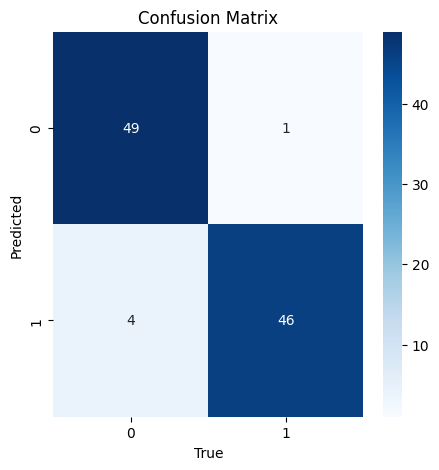

In [25]:
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred>0.5).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

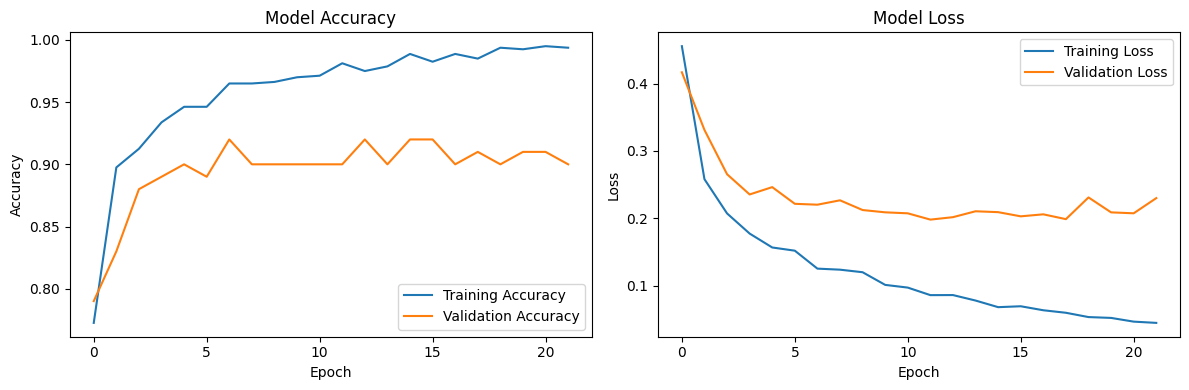

In [26]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

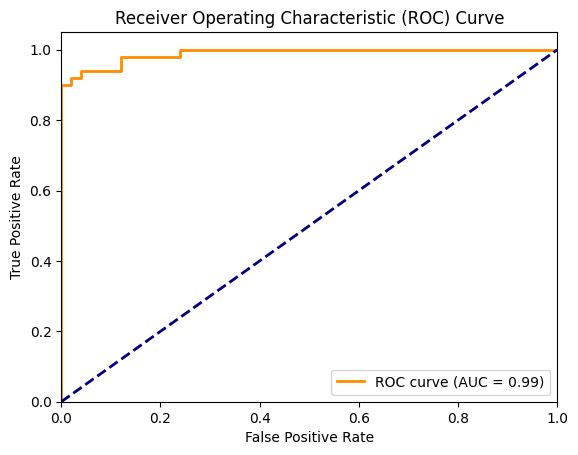

In [27]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()